# Segmenting and Clustering Neighborhoods in Toronto

Made by Femke Janssen         

## Assignment description

In this assignment, you will be required to explore, segment, and cluster the neighborhoods in the city of Toronto based on the postalcode and borough information.. However, unlike New York, the neighborhood data is not readily available on the internet. What is interesting about the field of data science is that each project can be challenging in its unique way, so you need to learn to be agile and refine the skill to learn new libraries and tools quickly depending on the project.

For the Toronto neighborhood data, a Wikipedia page exists that has all the information we need to explore and cluster the neighborhoods in Toronto. You will be required to scrape the Wikipedia page and wrangle the data, clean it, and then read it into a pandas  dataframe so that it is in a structured format like the New York dataset.

Once the data is in a structured format, you can replicate the analysis that we did to the New York City dataset to explore and cluster the neighborhoods in the city of Toronto.

## Getting the dataset from Wikipedia

In [1]:
#First, import packages
import pandas as pd
from bs4 import BeautifulSoup
import requests
import numpy as np
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize  # tranform JSON file into a pandas dataframe

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

### Scrape the data 

In [2]:
# get the response in the form of html
wikiurl="https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
table_class="wikitable sortable jquery-tablesorter"
response=requests.get(wikiurl)
print(response.status_code)

200


In [3]:
# parse data from the html into a beautifulsoup object
soup = BeautifulSoup(response.text, 'html.parser')
toronto_table=soup.find('table',{'class':"wikitable"})

In [4]:
df=pd.read_html(str(toronto_table))
# convert list to dataframe
df=pd.DataFrame(df[0])
df.head(15)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


## Process the data

In [5]:
#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
toronto_dropNotAssigned = df[df.Borough != 'Not assigned'].reset_index(drop=True)

In [6]:
#More than one neighborhood can exist in one postal code area. 
#For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: 
#Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma 
#as shown in row 11  in the above table.
toronto_grouped = toronto_dropNotAssigned.groupby(['Postal Code','Borough'], as_index=False).agg(lambda x: ','.join(x))

In [7]:
#If a cell has a borough but a Not assigned  neighborhood, then the neighborhood will be the same as the borough.
mask = toronto_grouped['Neighbourhood'] == "Not assigned"
toronto_grouped.loc[mask, 'Neighbourhood'] = toronto_grouped.loc[mask, 'Borough']

In [8]:
#The dataset now looks like this:
toronto_grouped.head(10)

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park"
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge"
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff, Cliffside West"


In [9]:
toronto_grouped.shape

(103, 3)

## Get the longitudes and latitudes

In [10]:
df_geo = pd.read_csv("C:/Users/femke/OneDrive/Documenten/Master jaar 1/Python vak/CAPSTONE/Geospatial_Coordinates.csv")
df_geo.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
#Merge the two datasets
df = pd.merge(toronto_grouped, df_geo, how='left', left_on = 'Postal Code', right_on = 'Postal Code')
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


## Cluster the neighbourhoods in Toronto

Get latitude and longitude of Toronto:

In [12]:
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


Make a map of Toronto with Folium:

In [13]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

Add markers:

In [14]:
for lat, lng, borough, neighbourhood in zip(
        df['Latitude'], 
        df['Longitude'], 
        df['Borough'], 
        df['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

Define Foursquare credentials and version:

In [15]:
CLIENT_ID = 'D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF' # your Foursquare ID
CLIENT_SECRET = 'L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG' # your Foursquare Secret
ACCESS_TOKEN = 'H0YXC1VODECFZBJIISXHMYLBPFDRNZI3LV5FLKZJRJ5ACH03' # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF
CLIENT_SECRET:L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG


Get the first neighbourhood name:

In [16]:
df.loc[0, 'Neighbourhood']

'Malvern, Rouge'

Get the neighourhoods latitude and longitude values:

In [17]:
neighbourhood_latitude = df.loc[0, 'Latitude'] # neighbourhood latitude value
neighbourhood_longitude = df.loc[0, 'Longitude'] # neighbourhood longitude value

neighbourhood_name = df.loc[0, 'Neighbourhood'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighbourhood_name, 
                                                               neighbourhood_latitude, 
                                                               neighbourhood_longitude))

Latitude and longitude values of Malvern, Rouge are 43.806686299999996, -79.19435340000001.


Get the top 100 venues that are in Marble Hill within a radius of 500 meters:

In [18]:

LIMIT = 100 # limit of number of venues returned by Foursquare API


radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighbourhood_latitude, 
    neighbourhood_longitude, 
    radius, 
    LIMIT)
url # display URL 

'https://api.foursquare.com/v2/venues/explore?&client_id=D1UF1ORKKDYML4KS4JVLZ0BWDVZ2RY4CAOVJHZICIVAY2CCF&client_secret=L1EA15VVOMW33CCJZB2YNJNJOQXWHYR2NZAZ4H2PBUVUZQTG&v=20180605&ll=43.806686299999996,-79.19435340000001&radius=500&limit=100'

Examine results with GET request:

In [19]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '60142dcca4365613b5e3e1e2'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Malvern',
  'headerFullLocation': 'Malvern, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 43.8111863045, 'lng': -79.18812958073042},
   'sw': {'lat': 43.80218629549999, 'lng': -79.2005772192696}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bb6b9446edc76b0d771311c',
       'name': 'Wendy’s',
       'location': {'crossStreet': 'Morningside & Sheppard',
        'lat': 43.80744841934756,
        'lng': -79.19905558052072,
        'labeledLatLngs': [{'label': 'display'

Function that extracts the category of the venue:

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean the json and structure it into a pandas dataframe:

In [21]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

<ipython-input-21-9de588fd8d99>:2: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  nearby_venues = json_normalize(venues) # flatten JSON


,name,categories,lat,lng
0,Wendy’s,Fast Food Restaurant,43.807448,-79.199056


In [22]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

1 venues were returned by Foursquare.


Create a function to repeat the same process to all the neighborhoods in Toronto:

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Write the code to run the above function on each neighborhood and create a new dataframe called toronto_venues:

In [24]:
toronto_venues = getNearbyVenues(names=df['Neighbourhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

Check the dataframe:

In [25]:
print(toronto_venues.shape)
toronto_venues.head(20)

(2121, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Sail Sushi,43.765951,-79.191275,Restaurant
5,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Big Bite Burrito,43.766299,-79.190720,Mexican Restaurant
6,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Enterprise Rent-A-Car,43.764076,-79.193406,Rental Car Location
7,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Woburn Medical Centre,43.766631,-79.192286,Medical Center
8,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Lawrence Ave E & Kingston Rd,43.767704,-79.189490,Intersection
9,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Eggsmart,43.767800,-79.190466,Breakfast Spot


Check how many venues were returned for each neighborhood:

In [26]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",21,21,21,21,21,21
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",24,24,24,24,24,24
...,...,...,...,...,...,...
"Willowdale, Willowdale East",35,35,35,35,35,35
"Willowdale, Willowdale West",5,5,5,5,5,5
Woburn,3,3,3,3,3,3


Find out how many unique categories can be curated from all the returned venues:

In [27]:
print('There are {} unique categories in all the returned venues.'.format(len(toronto_venues['Venue Category'].unique())))

There are 280 unique categories in all the returned venues.


#### Analyze each neighbourhood

In [28]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(20)

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Examine new dataframe:

In [29]:
toronto_onehot.shape

(2121, 281)

Group rows by neighborhood by taking the mean of the frequency of occurrence of each category:

In [30]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,"Willowdale, Willowdale East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.028571,0.0,0.0,0.0,0.0,0.0,0.0
91,"Willowdale, Willowdale West",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
92,Woburn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
93,Woodbine Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
toronto_grouped.shape

(95, 281)

Print each neighborhood along with the top 5 most common venues:

In [32]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                       venue  freq
0               Skating Rink  0.25
1             Breakfast Spot  0.25
2                     Lounge  0.25
3  Latin American Restaurant  0.25
4          Accessories Store  0.00


----Alderwood, Long Branch----
                venue  freq
0         Pizza Place  0.33
1                 Pub  0.17
2  Athletics & Sports  0.17
3                 Gym  0.17
4         Coffee Shop  0.17


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.10
1  Coffee Shop  0.10
2         Park  0.05
3        Diner  0.05
4  Bridal Shop  0.05


----Bayview Village----
                 venue  freq
0   Chinese Restaurant  0.25
1  Japanese Restaurant  0.25
2                 Café  0.25
3                 Bank  0.25
4    Accessories Store  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0          Hobby Shop  0.08
1         Coffee Shop  0.08
2      Sandwich Place  0.08
3  Italian Restaurant  0.08
4  

4         Movie Theater  0.05


----Kennedy Park, Ionview, East Birchmount Park----
               venue  freq
0  Convenience Store   0.2
1     Discount Store   0.2
2        Bus Station   0.2
3   Department Store   0.2
4        Coffee Shop   0.2


----Kensington Market, Chinatown, Grange Park----
                           venue  freq
0                           Café  0.08
1                    Coffee Shop  0.06
2  Vegetarian / Vegan Restaurant  0.06
3             Mexican Restaurant  0.05
4          Vietnamese Restaurant  0.05


----Kingsview Village, St. Phillips, Martin Grove Gardens, Richview Gardens----
                 venue  freq
0          Pizza Place  0.25
1                 Park  0.25
2             Bus Line  0.25
3       Sandwich Place  0.25
4  Monument / Landmark  0.00


----Lawrence Manor, Lawrence Heights----
                    venue  freq
0          Clothing Store  0.23
1  Furniture / Home Store  0.15
2       Accessories Store  0.08
3     Arts & Crafts Store  0.08
4        

### Put this into a pandas dataframe

Write a function to sort the venues in descending order:

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Create the new dataframe and display the top 10 venues for each neighbourhood:

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Lounge,Breakfast Spot,Skating Rink,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
1,"Alderwood, Long Branch",Pizza Place,Athletics & Sports,Gym,Coffee Shop,Pub,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Ice Cream Shop,Shopping Mall,Sandwich Place,Middle Eastern Restaurant,Diner,Supermarket,Restaurant,Sushi Restaurant
3,Bayview Village,Japanese Restaurant,Chinese Restaurant,Bank,Café,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Discount Store
4,"Bedford Park, Lawrence Manor East",Hobby Shop,Italian Restaurant,Coffee Shop,Sandwich Place,Grocery Store,Japanese Restaurant,Sushi Restaurant,Juice Bar,Comfort Food Restaurant,Butcher


## Cluster the neighbourhoods

In [35]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

In [36]:
toronto_grouped_clustering.head()

,Accessories Store,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Make an elbow plot to display how many clusters I should make

In [37]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(toronto_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

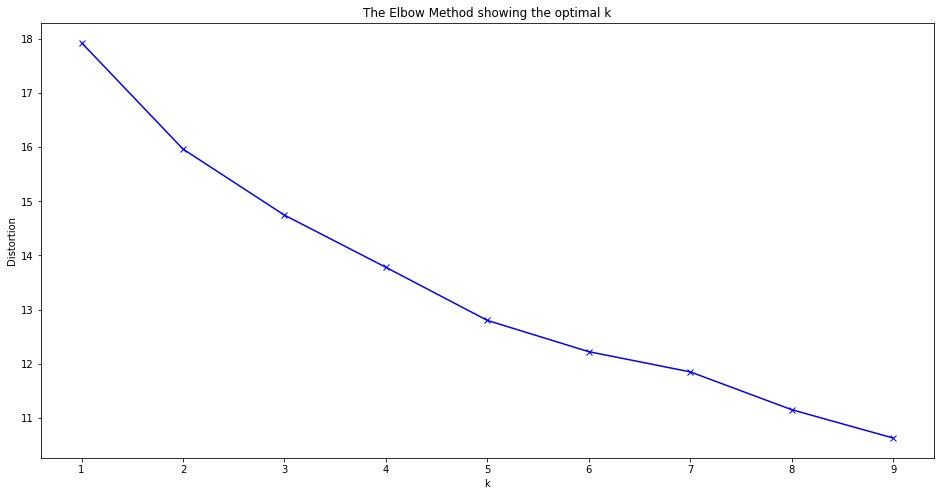

In [38]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

**Actually, this elbow plot is horrible, so I will just guess that I have to make 5 clusters**

Run k-means:

In [39]:
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [40]:
kmeans.labels_.astype(int) 

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 4, 1,
       0, 1, 1, 1, 1, 1, 0])

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighbourhood:

In [41]:
# add clustering labels
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,3.0,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Discount Store
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Bank,Breakfast Spot,Medical Center,Intersection,Electronics Store,Mexican Restaurant,Restaurant,Rental Car Location,Doner Restaurant,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Thai Restaurant,Bank,Gas Station,Caribbean Restaurant,Athletics & Sports,Fried Chicken Joint,Hakka Restaurant,Bakery,Ethiopian Restaurant,Electronics Store


**Visualize the results!:**

In [45]:
#Cluster as integer, not float:
#toronto_merged

# displaying the datatypes 
display(toronto_merged.dtypes)

toronto_merged = toronto_merged.fillna(0)
  
# converting 'Weight' from float to int 
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int) 
  
# displaying the datatypes 
#display(toronto_merged.dtypes) 

Postal Code                object
Borough                    object
Neighbourhood              object
Latitude                  float64
Longitude                 float64
Cluster Labels            float64
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [46]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        toronto_merged['Latitude'], 
        toronto_merged['Longitude'], 
        toronto_merged['Neighbourhood'], 
        toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

In [47]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Scarborough,0,Playground,Park,Intersection,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
16,Scarborough,0,0,0,0,0,0,0,0,0,0,0
20,North York,0,0,0,0,0,0,0,0,0,0,0
21,North York,0,0,0,0,0,0,0,0,0,0,0
23,North York,0,Park,Convenience Store,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant
25,North York,0,Park,Bus Stop,Food & Drink Shop,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
40,East York,0,Park,Intersection,Convenience Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
50,Downtown Toronto,0,Park,Playground,Trail,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
74,York,0,Park,Women's Store,Pool,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore
90,Etobicoke,0,Park,River,Yoga Studio,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant


In [48]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Scarborough,1,Bar,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Discount Store
2,Scarborough,1,Bank,Breakfast Spot,Medical Center,Intersection,Electronics Store,Mexican Restaurant,Restaurant,Rental Car Location,Doner Restaurant,Discount Store
3,Scarborough,1,Coffee Shop,Korean BBQ Restaurant,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
4,Scarborough,1,Thai Restaurant,Bank,Gas Station,Caribbean Restaurant,Athletics & Sports,Fried Chicken Joint,Hakka Restaurant,Bakery,Ethiopian Restaurant,Electronics Store
5,Scarborough,1,Women's Store,Playground,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
...,...,...,...,...,...,...,...,...,...,...,...,...
96,North York,1,Pizza Place,Intersection,Furniture / Home Store,Gym,Drugstore,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
99,Etobicoke,1,Pizza Place,Discount Store,Sandwich Place,Intersection,Chinese Restaurant,Coffee Shop,Middle Eastern Restaurant,Donut Shop,Distribution Center,Dog Run
100,Etobicoke,1,Pizza Place,Park,Sandwich Place,Bus Line,Donut Shop,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
101,Etobicoke,1,Grocery Store,Pizza Place,Sandwich Place,Fast Food Restaurant,Beer Store,Fried Chicken Joint,Pharmacy,Greek Restaurant,Event Space,Electronics Store


In [49]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,Etobicoke,2,Locksmith,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
97,North York,2,Baseball Field,Yoga Studio,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store,Discount Store


In [50]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,3,Fast Food Restaurant,Yoga Studio,Eastern European Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Electronics Store
